In [1]:
# from __future__ import print_function

In [1]:
import sys
'Python version: %s.%s' % (sys.version_info.major, sys.version_info.minor)

'Python version: 3.8'

In [4]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import graphviz

In [5]:
print('Requests: %s' % requests.__version__)
print('BeautifulSoup: %s'% bs4.__version__)
print('Pandas: %s'% pd.__version__)
print('Graphviz: %s' % graphviz.__version__)
%matplotlib inline

Requests: 2.27.1
BeautifulSoup: 4.10.0
Pandas: 1.3.5
Graphviz: 0.19.1


# How to visualize an XML sitemap using Python

<img src="static/sitemap_graph_2_layer.png" width="700">

A rich sitemap might contain page descriptions and modification dates along with image and video metadata, but the basic purpose of a sitemap is to provide a list the pages on a domain that are accessible to users and web crawlers. In this post, we'll use Python and a toolkit of libraries to parse, categorize, and visualize an XML sitemap. This will involve:
- extracting the page URLs
- categorizing URLs by page type
- plotting a sitemap graph tree

## Extracting URLs 

We'll use the www.sportchek.ca sitemap as an example. It is hosted on their domain and open to the public. Like most large sites, the entire sitemap is split across multiple XML files. These are indexed at the [/sitemap.xml](https://www.sportchek.ca/sitemap.xml) page.

We start by opening the url in Python using requests and then instantiate a "soup" object containing the page content.

In [16]:
url = 'https://konstantinklepikov.github.io/sitemap_index.xml'
page = requests.get(url)
print('Loaded page with: %s' % page)

sitemap_index = BeautifulSoup(page.content, 'html.parser')
print('Created %s object' % type(sitemap_index))

Loaded page with: <Response [200]>
Created <class 'bs4.BeautifulSoup'> object


Next we can pull the XML sitemap links, which live within the `<loc>` tags.

In [17]:
sitemap_index.findAll('loc')

[<loc>https://konstantinklepikov.github.io/sitemap.xml</loc>,
 <loc>https://konstantinklepikov.github.io/myknowlegebase/sitemap.xml</loc>]

In [18]:
urls = [element.text for element in sitemap_index.findAll('loc')]
urls

['https://konstantinklepikov.github.io/sitemap.xml',
 'https://konstantinklepikov.github.io/myknowlegebase/sitemap.xml']

With some investigation of the XML format for each file above, we again see that URLs can be identified by searching for `<loc>` tags. These URLs can be extracted the same as the XML links were from the index. We loop over the XML documents, appending all sitemap URLs to a list.

In [19]:
%%time

def extract_links(url):
    ''' Open an XML sitemap and find content wrapped in <loc> tags. '''
    
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    links = [element.text for element in soup.findAll('loc')]
    
    return links

sitemap_urls = []
for url in urls:
    links = extract_links(url)
    sitemap_urls += links

CPU times: user 48.2 ms, sys: 5.59 ms, total: 53.7 ms
Wall time: 578 ms


In [20]:
'Found {:,} URLs in the sitemap'.format(len(sitemap_urls))

'Found 362 URLs in the sitemap'

Let's write these to a file that can be opened in Excel.

In [21]:
with open('../dist/sitemap_urls.dat', 'w') as f:
    for url in sitemap_urls:
        f.write(url + '\n')

## Categorization

Let's start by loading in the URLs we wrote to a file.

In [25]:
with open('../dist/sitemap_urls.dat', 'r') as urls:
    sitemap_urls = urls.read().splitlines()
print('Loaded {:,} URLs'.format(len(sitemap_urls)))

Loaded 362 URLs


Site-specific categorization such as identifying display listing pages and product pages can be done by applying filters over the URL list. Python is great for this because filters can be very detailed and chained together, plus your results can be reproduced by simply running the script!

On the other hand, we could take a different approach and - instead of filtering for specific URLs - apply an automated algorithm to peel back our sites layers and find the general structure.

In [26]:
def peel_layers(urls, layers=3):
    ''' Builds a dataframe containing all unique page identifiers up
    to a specified depth and counting the number of sub-pages for each.
    Prints results to a CSV file.

    urls : list
        List of page URLs.

    layers : int
        Depth of automated URL search. Large values for this parameter
        may cause long runtimes depending on the number of URLs.
    '''

    # Store results in a dataframe
    sitemap_layers = pd.DataFrame()

    # Get base levels
    bases = pd.Series([url.split('//')[-1].split('/')[0] for url in urls])
    sitemap_layers[0] = bases

    # Get specified number of layers
    for layer in range(1, layers+1):

        page_layer = []
        for url, base in zip(urls, bases):
            try:
                page_layer.append(url.split(base)[-1].split('/')[layer])
            except:
                # There is nothing that deep!
                page_layer.append('')

        sitemap_layers[layer] = page_layer

    # Count and drop duplicate rows + sort
    sitemap_layers = sitemap_layers.groupby(list(range(0, layers+1)))[0].count()\
                     .rename('counts').reset_index()\
                     .sort_values('counts', ascending=False)\
                     .sort_values(list(range(0, layers)), ascending=True)\
                     .reset_index(drop=True)
    
    # Convert column names to string types and export
    sitemap_layers.columns = [str(col) for col in sitemap_layers.columns]
    sitemap_layers.to_csv('../dist/sitemap_layers.csv', index=False)

    # Return the dataframe
    return sitemap_layers

The `peel_layers` function also counts the number of pages for each layer. These can be accessed by looking at the output dataframe in Python or opening the output file `sitemap_layers.csv` in Excel. Let's do this for three layers.

In [29]:
sitemap_layers = peel_layers(urls=sitemap_urls, layers=3)
sitemap_layers

,0,1,2,3,counts
0,konstantinklepikov.github.io,,,,1
1,konstantinklepikov.github.io,2019,05,15,1
2,konstantinklepikov.github.io,2019,05,31,1
3,konstantinklepikov.github.io,2019,05,22,1
4,konstantinklepikov.github.io,2019,06,27,1
...,...,...,...,...,...
357,konstantinklepikov.github.io,tag,time-complexity.html,,1
358,konstantinklepikov.github.io,tag,translating.html,,1
359,konstantinklepikov.github.io,tag,two-Layer.html,,1
360,konstantinklepikov.github.io,tag,zerocode.html,,1


At this point you may be inclined to continue with further analysis in Excel, but we'll invite you to carry on in Python.

## Filtering

The `peel_layers` function returns a [Pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) that we stored in the variable `sitemap_layers`. This contains the exported `.csv` data as a table inside Python, and it can be filtered or otherwise modified in any way. Say, for example, we are interested in the number of pages relating to hockey. We may want to run a script like this one that searches for rows with "hockey" in the third layer:

In [32]:
counts = sitemap_layers[sitemap_layers['3'].apply(
            lambda string: 'python' in string)]\
            ['counts'].sum()
    
print('%d total hockey pages' % counts)

21 total hockey pages


What we do here is filter the dataframe (as seen below) and then sum the counts column.

In [33]:
sitemap_fltr = sitemap_layers[sitemap_layers['3'].apply(lambda string: 'python' in string)]
sitemap_fltr

,0,1,2,3,counts
44,konstantinklepikov.github.io,myknowlegebase,lists,python-standart-library.html,1
45,konstantinklepikov.github.io,myknowlegebase,lists,python-logging.html,1
46,konstantinklepikov.github.io,myknowlegebase,lists,python-datamodel.html,1
61,konstantinklepikov.github.io,myknowlegebase,notes,python-interptetator-and-env-utils.html,1
62,konstantinklepikov.github.io,myknowlegebase,notes,python-filesystem.html,1
63,konstantinklepikov.github.io,myknowlegebase,notes,python-descriptors.html,1
64,konstantinklepikov.github.io,myknowlegebase,notes,python-decorator.html,1
65,konstantinklepikov.github.io,myknowlegebase,notes,python-cryptography.html,1
75,konstantinklepikov.github.io,myknowlegebase,notes,pdb-python-debugger.html,1
81,konstantinklepikov.github.io,myknowlegebase,notes,python-glossary.html,1


This table can be saved to an Excel readable format using the `to_csv` function.

In [17]:
sitemap_fltr.to_csv('hockey_pages.csv', index=False)

Filtering conditions can be as specific as you desire. For example if you want to find snowboard and ski pages:

In [34]:
sitemap_fltr = sitemap_layers[sitemap_layers['3'].apply(lambda string: 'python' in string or\
                                                                       'pandas' in string)]
sitemap_fltr

,0,1,2,3,counts
44,konstantinklepikov.github.io,myknowlegebase,lists,python-standart-library.html,1
45,konstantinklepikov.github.io,myknowlegebase,lists,python-logging.html,1
46,konstantinklepikov.github.io,myknowlegebase,lists,python-datamodel.html,1
61,konstantinklepikov.github.io,myknowlegebase,notes,python-interptetator-and-env-utils.html,1
62,konstantinklepikov.github.io,myknowlegebase,notes,python-filesystem.html,1
63,konstantinklepikov.github.io,myknowlegebase,notes,python-descriptors.html,1
64,konstantinklepikov.github.io,myknowlegebase,notes,python-decorator.html,1
65,konstantinklepikov.github.io,myknowlegebase,notes,python-cryptography.html,1
75,konstantinklepikov.github.io,myknowlegebase,notes,pdb-python-debugger.html,1
77,konstantinklepikov.github.io,myknowlegebase,notes,pandas.html,1


Oops, it looks like "skills-development" is included as is contains "ski". Let's exclude this term.

Other useful filtering tools are the `split` and `len` functions. For instance, we could find all the pages with at least four "-" characters in the 3rd layer.

In [35]:
sitemap_fltr = sitemap_layers[sitemap_layers['3'].apply(lambda string: len(string.split('-')) >= 4)]
sitemap_fltr

,0,1,2,3,counts
53,konstantinklepikov.github.io,myknowlegebase,lists,full-path-to-current-directory.html,1
61,konstantinklepikov.github.io,myknowlegebase,notes,python-interptetator-and-env-utils.html,1
76,konstantinklepikov.github.io,myknowlegebase,notes,paste-images-from-clipboard.html,1
91,konstantinklepikov.github.io,myknowlegebase,notes,shell-comans-in-one-line.html,1
98,konstantinklepikov.github.io,myknowlegebase,notes,remove-dict-key-python.html,1
113,konstantinklepikov.github.io,myknowlegebase,notes,how-to-set-nonstring-env-variables.html,1
155,konstantinklepikov.github.io,myknowlegebase,notes,use-keyboard-shortcuts-for-editing.html,1
177,konstantinklepikov.github.io,myknowlegebase,notes,%D0%B7%D0%B0%D0%BF%D1%83%D1%81%D0%BA-uvicorn-%...,1
179,konstantinklepikov.github.io,myknowlegebase,notes,%D0%B4%D0%B5%D0%BA%D0%BE%D1%80%D0%B0%D1%82%D0%...,1
180,konstantinklepikov.github.io,myknowlegebase,notes,%D0%BA%D0%B0%D0%BA-%D1%80%D0%B0%D0%B1%D0%BE%D1...,1


In this example, we split the string into a list of substrings as separated by the dashes and check if the list has more than 3 elements.

Working with Pandas DataFrames in Python can seem very complicated - especially for those new to Python - but the rewards are great.

## Visualizing sitemap

Storing data in tables is the only reasonable option, but it's not always the best way to view the data. This is especially true when sharing it with others.

The sitemap dataframe we've generated can be nicely visualized using graphviz, where paths are illustrated with nodes and edges. The nodes contain site page layers and the edges are labelled by the number of sub-pages existing within that path.

In [45]:
def make_sitemap_graph(df, layers=3, limit=50, size='8,5'):
    ''' Make a sitemap graph up to a specified layer depth.
    
    sitemap_layers : DataFrame
        The dataframe created by the peel_layers function 
        containing sitemap information.
    
    layers : int
        Maximum depth to plot.
        
    limit : int
        The maximum number node edge connections. Good to set this
        low for visualizing deep into site maps.
    '''
    
    
    # Check to make sure we are not trying to plot too many layers
    if layers > len(df) - 1:
        layers = len(df)-1
        print('There are only %d layers available to plot, setting layers=%d'
              % (layers, layers))
    
    
    # Initialize graph
    f = graphviz.Digraph('sitemap', filename='sitemap_graph_%d_layer' % layers)
    f.body.extend(['rankdir=LR\n', 'size="%s"' % size])
    
    
    def add_branch(f, names, vals, limit, connect_to=''):
        ''' Adds a set of nodes and edges to nodes on the previous layer. '''
        
        # Get the currently existing node names
        node_names = [item.split('"')[1] for item in f.body if 'label' in item]
        
        # Only add a new branch it it will connect to a previously created node
        if connect_to:
            if connect_to in node_names:
                for name, val in list(zip(names, vals))[:limit]:
                    f.node(name='%s-%s' % (connect_to, name), label=name)
                    f.edge(connect_to, '%s-%s' % (connect_to, name), label='{:,}'.format(val))
        

    f.attr('node', shape='rectangle') # Plot nodes as rectangles
    
    # Add the first layer of nodes
    for name, counts in df.groupby(['0'])['counts'].sum().reset_index()\
                          .sort_values(['counts'], ascending=False).values:
        f.node(name=name, label='{} ({:,})'.format(name, counts))
    
    if layers == 0:
        return f
    
    f.attr('node', shape='oval') # Plot nodes as ovals
    f.graph_attr.update()
    
    # Loop over each layer adding nodes and edges to prior nodes
    for i in range(1, layers+1):
        cols = [str(i_) for i_ in range(i)]
        for k in df[cols].drop_duplicates().values:
            
            # Compute the mask to select correct data
            mask = True
            for j, ki in enumerate(k):
                mask &= df[str(j)] == ki
                
            # Select the data then count branch size, sort, and truncate
            data = df[mask].groupby([str(i)])['counts'].sum()\
                    .reset_index().sort_values(['counts'], ascending=False)
                
            # Add to the graph
            add_branch(f,
                       names=data[str(i)].values,
                       vals=data['counts'].values,
                       limit=limit,
                       connect_to='-'.join(['%s']*i) % tuple(k))
            
    return f


def apply_style(f, style, title=''):
    ''' Apply the style and add a title if desired. More styling options are
    documented here: http://www.graphviz.org/doc/info/attrs.html#d:style
    
    f : graphviz.dot.Digraph
        The graph object as created by graphviz.
    
    style : str
        Available styles: 'light', 'dark'
        
    title : str
        Optional title placed at the bottom of the graph.
    '''
    
    dark_style = {
        'graph': {
            'label': title,
            'bgcolor': '#3a3a3a',
            'fontname': 'Helvetica',
            'fontsize': '18',
            'fontcolor': 'white',
        },
        'nodes': {
            'style': 'filled',
            'color': 'white',
            'fillcolor': 'black',
            'fontname': 'Helvetica',
            'fontsize': '14',
            'fontcolor': 'white',
        },
        'edges': {
            'color': 'white',
            'arrowhead': 'open',
            'fontname': 'Helvetica',
            'fontsize': '12',
            'fontcolor': 'white',
        }
    }

    light_style = {
        'graph': {
            'label': title,
            'fontname': 'Helvetica',
            'fontsize': '18',
            'fontcolor': 'black',
        },
        'nodes': {
            'style': 'filled',
            'color': 'black',
            'fillcolor': '#dbdddd',
            'fontname': 'Helvetica',
            'fontsize': '14',
            'fontcolor': 'black',
        },
        'edges': {
            'color': 'black',
            'arrowhead': 'open',
            'fontname': 'Helvetica',
            'fontsize': '12',
            'fontcolor': 'black',
        }
    }
    
    if style == 'light':
        apply_style = light_style
            
    elif style == 'dark':
        apply_style = dark_style
        
    f.graph_attr = apply_style['graph']
    f.node_attr = apply_style['nodes']
    f.edge_attr = apply_style['edges']
    
    return f

The code that builds and exports this visualization is contained within a function called `make_sitemap_graph` that takes in our data and the number of layers deep we wish to see. For example we can do:

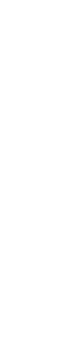

In [46]:
f = make_sitemap_graph(sitemap_layers, layers=2)
f = apply_style(f, 'light', title='Konstantin Klepikov sitemap')
f.render(cleanup=True)
f

Or we can use the dark style:

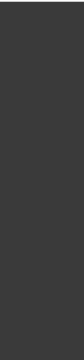

In [47]:
f = make_sitemap_graph(sitemap_layers, layers=2)
f = apply_style(f, 'dark')
f.render(cleanup=True)
f

Setting `layers=3` we see that our graph is already very large! Here we set `size=35` to create a higher resolution PDF file where the details are clearly visible.

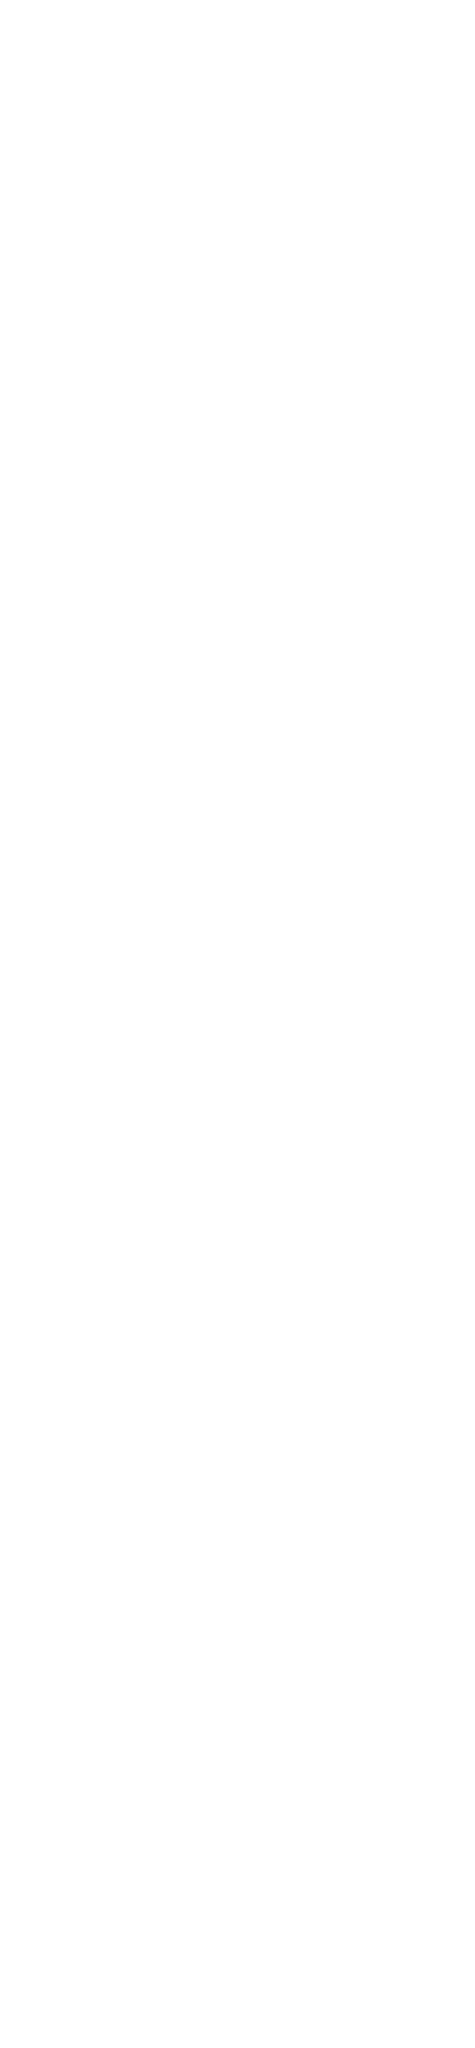

In [48]:
f = make_sitemap_graph(sitemap_layers, layers=3, size='35')
f = apply_style(f, 'light')
f.render(cleanup=True)
f

Another useful feature built into the graphing script is the ability to limit branch size. This can let us create deep sitemap visualizations that don't grow out of control. For example, limiting each branch to the top three (in terms of recursive page count):

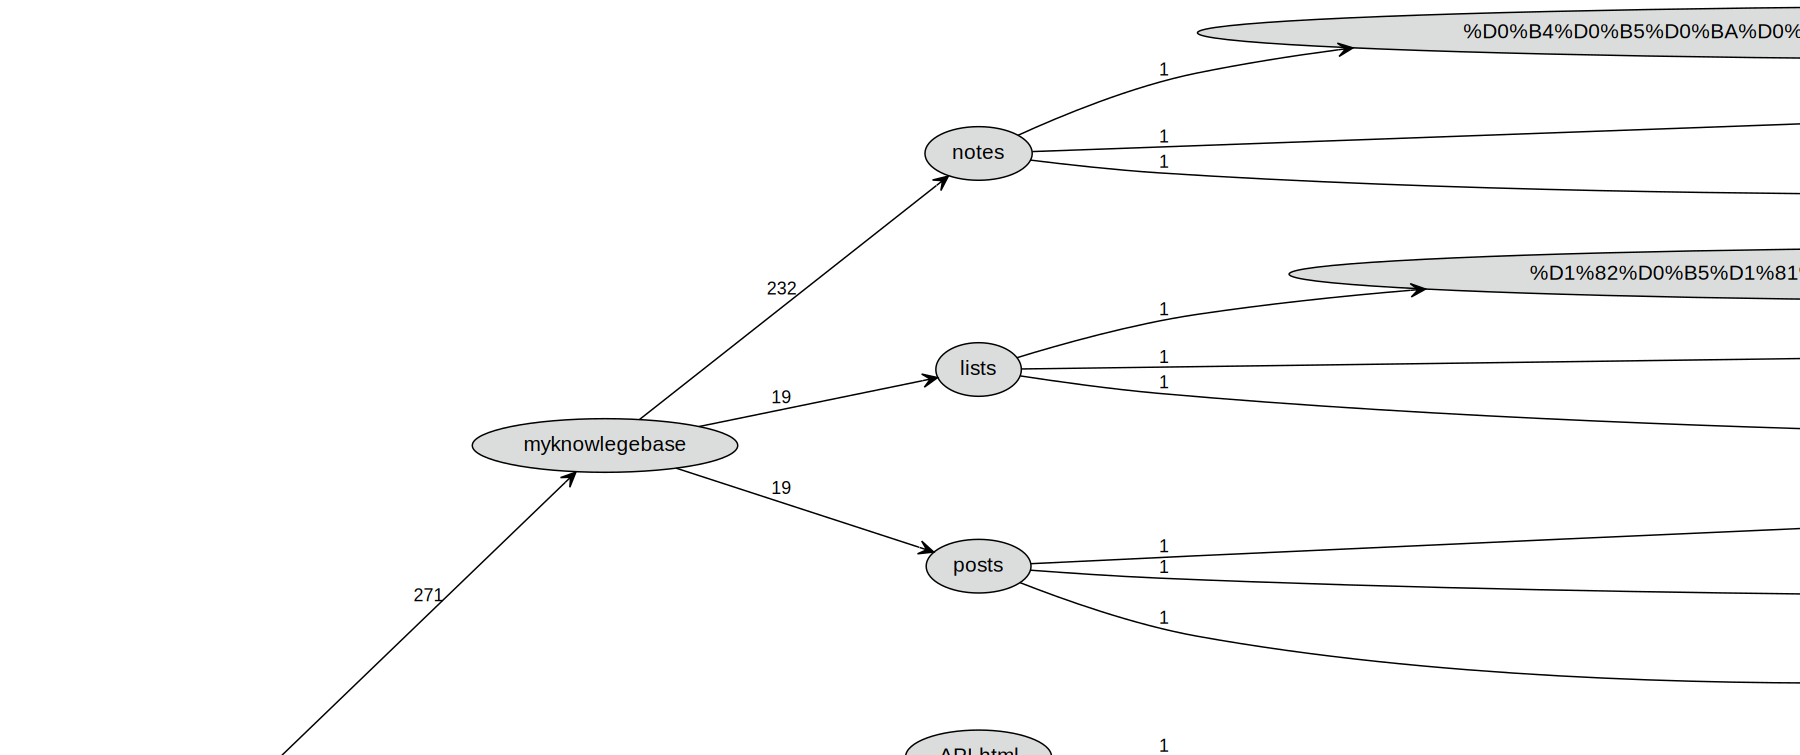

In [49]:
sitemap_layers = peel_layers(urls=sitemap_urls, layers=5)
f = make_sitemap_graph(sitemap_layers, layers=5, limit=3, size='25')
f = apply_style(f, 'light')
f.render(cleanup=True)
f

## Summary and Script Usage

In this post we have shown how Python can be used to extract, categorize and visualize an XML sitemap. The code we looked at has been optimized for your personal use and aggregated into three Python scripts that can be downloaded here:

[XML sitemap extraction tool](https://github.com/ayima)

These can be leveraged to automate URL extraction, categorization and visualization for the sitemap of your choice. For usage instructions, please make sure to check out the [online source code repository](https://github.com/ayima).

Thanks for reading, we hope you found this tutorial useful. If you run into any problems using our automated XML sitemap retrieval scripts we are here to help! You can reach us on twitter [@ayima](https://twitter.com/ayima).